In [1]:
# Импорт и настройки данных

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,4)

In [2]:
# В этой ячейке проверяем наличие основных колонок и типы данных

DATA_PATH = 'data/spotify_tracks.csv'
assert os.path.exists(DATA_PATH), f'Файл {DATA_PATH} не найден. Положите CSV в папку data/'

df = pd.read_csv(DATA_PATH)
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [3]:
# Обзор файла и пропуски
display(df.info())
display(df.describe(include='all').T)

miss = df.isna().sum().sort_values(ascending=False)
display(miss[miss>0].head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
artist,2000,835,Rihanna,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
song,2000,1879,Sorry,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_ms,2000.0,NaN,NaN,NaN,228748.1245,39136.569008,113000.0,203580.0,223279.5,248133.0,484146.0
explicit,2000,2,False,1449,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2000.0,NaN,NaN,NaN,2009.494,5.85996,1998.0,2004.0,2010.0,2015.0,2020.0
popularity,2000.0,NaN,NaN,NaN,59.8725,21.335577,0.0,56.0,65.5,73.0,89.0
danceability,2000.0,NaN,NaN,NaN,0.667438,0.140416,0.129,0.581,0.676,0.764,0.975
energy,2000.0,NaN,NaN,NaN,0.720366,0.152745,0.0549,0.622,0.736,0.839,0.999
key,2000.0,NaN,NaN,NaN,5.378,3.615059,0.0,2.0,6.0,8.0,11.0
loudness,2000.0,NaN,NaN,NaN,-5.512434,1.933482,-20.514,-6.49025,-5.285,-4.16775,-0.276


Series([], dtype: int64)

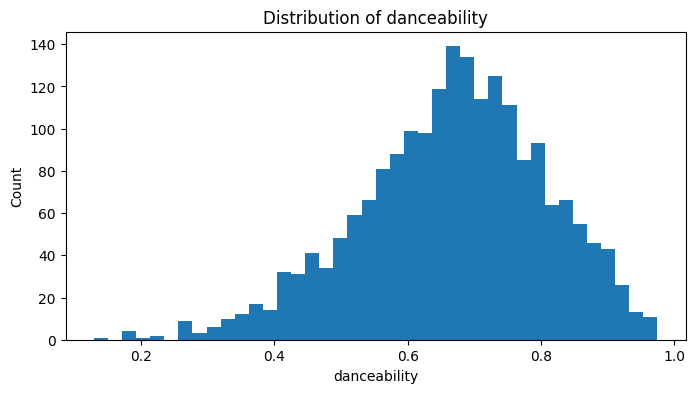

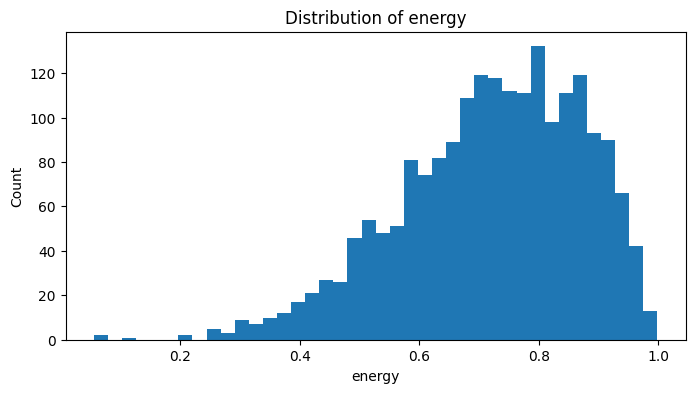

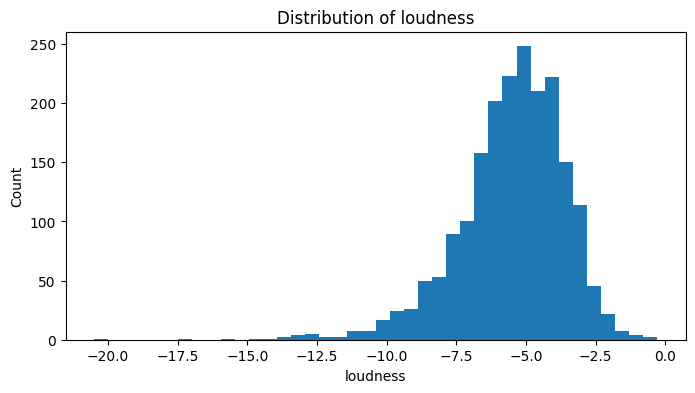

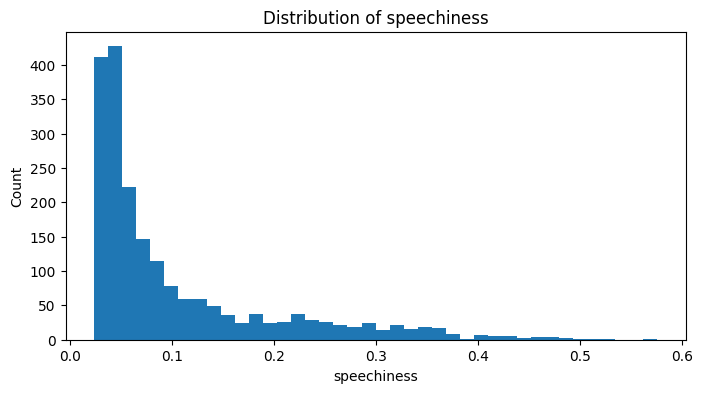

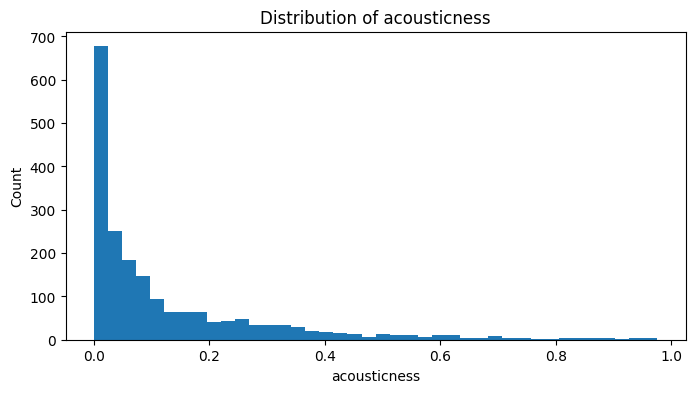

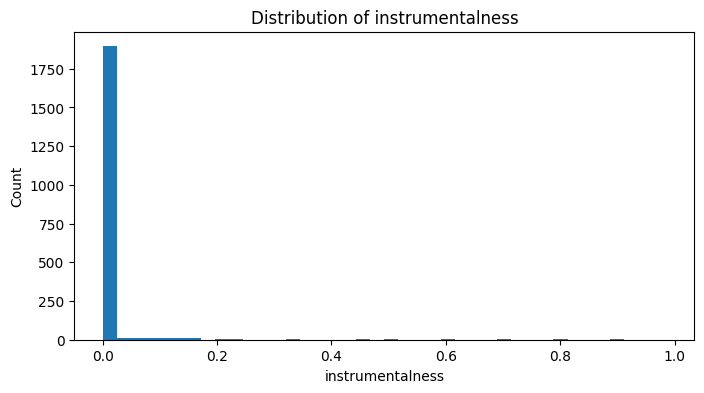

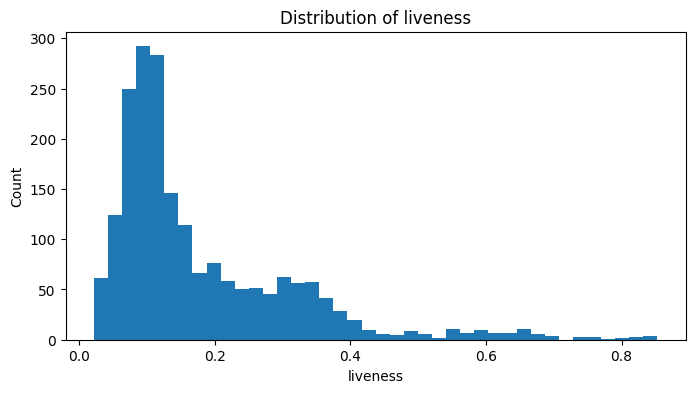

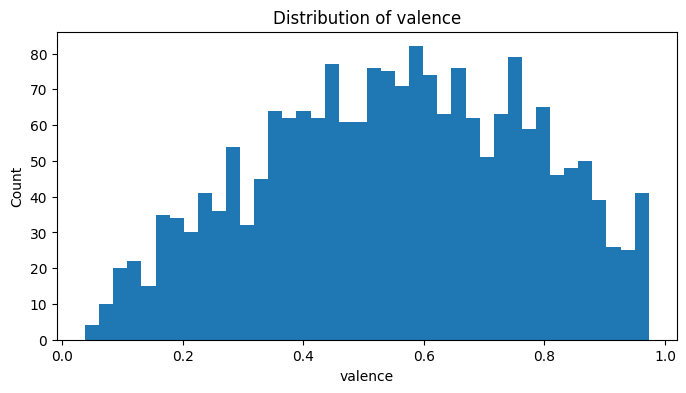

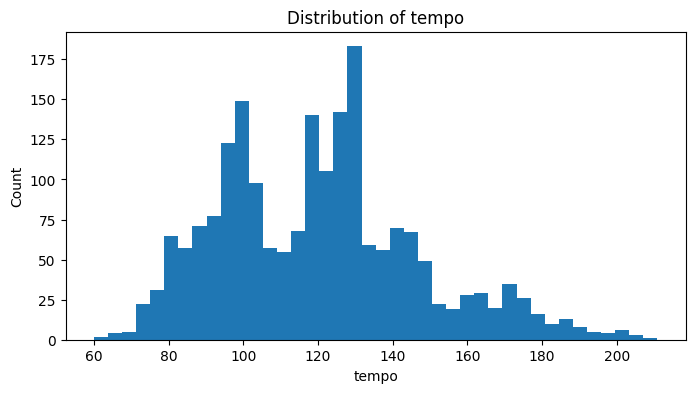

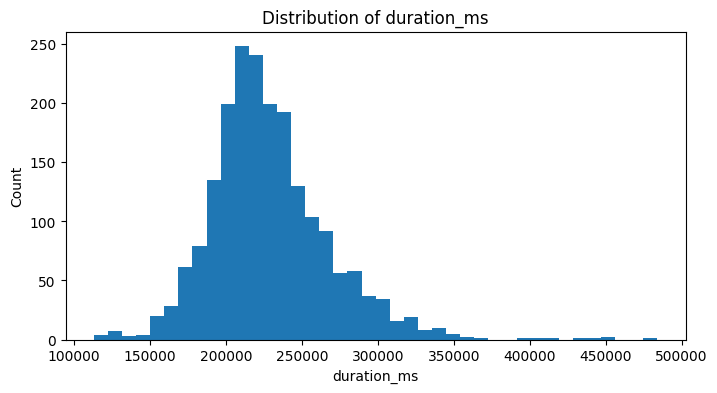

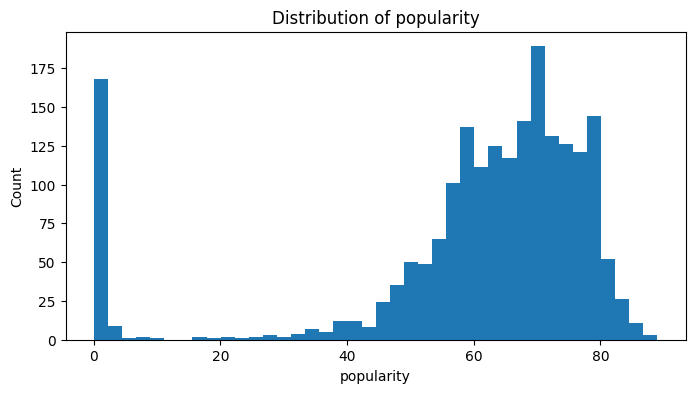

In [4]:
# Выбираем типичные аудио-фичи

candidates = ['danceability','energy','loudness','speechiness',
              'acousticness','instrumentalness','liveness','valence','tempo','duration_ms','popularity']
audio_features = [c for c in candidates if c in df.columns]
audio_features
for col in audio_features:
    plt.figure()
    plt.hist(df[col].dropna(), bins=40)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


In [5]:
if 'popularity' in df.columns:
    num = df.select_dtypes(include=[np.number])
    corr_with_target = num.corr()['popularity'].sort_values(ascending=False)
    display(corr_with_target)
else:
    print('Нет колонки "popularity" — выберите другую целевую колонку.')


popularity          1.000000
duration_ms         0.050617
loudness            0.030632
acousticness        0.024619
speechiness         0.021162
key                 0.014823
tempo               0.014288
danceability       -0.003546
year               -0.003825
liveness           -0.009856
energy             -0.014021
valence            -0.016142
mode               -0.021353
instrumentalness   -0.048059
Name: popularity, dtype: float64

In [6]:
df_fe = df.copy()
# duration -> minutes
if 'duration_ms' in df_fe.columns:
    df_fe['duration_min'] = df_fe['duration_ms'] / 60000

# title_len
if 'track_name' in df_fe.columns:
    df_fe['title_len'] = df_fe['track_name'].fillna('').str.len()

# release year
if 'album_release_date' in df_fe.columns:
    df_fe['release_year'] = pd.to_datetime(df_fe['album_release_date'], errors='coerce').dt.year

# flag explicit
if 'explicit' in df_fe.columns:
    df_fe['is_explicit'] = df_fe['explicit'].astype(int)

# Проверьте корреляцию новых колонок с таргетом
new_feats = [c for c in ['duration_min','title_len','release_year','is_explicit'] if c in df_fe.columns]
if 'popularity' in df_fe.columns:
    display(df_fe[new_feats + ['popularity']].corr()['popularity'].sort_values(ascending=False))
else:
    print('Нет popularity')


popularity      1.000000
duration_min    0.050617
is_explicit     0.046605
Name: popularity, dtype: float64

In [7]:
df_fe = df.copy()
# duration -> minutes
if 'duration_ms' in df_fe.columns:
    df_fe['duration_min'] = df_fe['duration_ms'] / 60000

# title_len
if 'track_name' in df_fe.columns:
    df_fe['title_len'] = df_fe['track_name'].fillna('').str.len()

# release year
if 'album_release_date' in df_fe.columns:
    df_fe['release_year'] = pd.to_datetime(df_fe['album_release_date'], errors='coerce').dt.year

# flag explicit
if 'explicit' in df_fe.columns:
    df_fe['is_explicit'] = df_fe['explicit'].astype(int)

# Проверьте корреляцию новых колонок с таргетом
new_feats = [c for c in ['duration_min','title_len','release_year','is_explicit'] if c in df_fe.columns]
if 'popularity' in df_fe.columns:
    display(df_fe[new_feats + ['popularity']].corr()['popularity'].sort_values(ascending=False))
else:
    print('Нет popularity')


popularity      1.000000
duration_min    0.050617
is_explicit     0.046605
Name: popularity, dtype: float64

In [8]:
# Подготовка X и y
target = 'popularity'  # измените, если у вас другая целевая
assert target in df_fe.columns, 'Нужен столбец popularity в датасете'
y = df_fe[target]

# Уберём текстовые/ID поля из X
drop_cols = [c for c in df_fe.columns if df_fe[c].dtype == 'O' or c.lower() in ['id','uri','href','track_id','artist_id','name']]
X = df_fe.drop(columns=[c for c in drop_cols if c in df_fe.columns])
# уберем целевой столбец если попал
if target in X.columns:
    X = X.drop(columns=[target])
# оставим только числовые
X = X.select_dtypes(include=[np.number]).copy()
X.shape

(2000, 15)

In [9]:
from sklearn.model_selection import KFold, cross_val_score
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'DecisionTree': DecisionTreeRegressor(max_depth=8, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'HistGB': HistGradientBoostingRegressor(random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, model in models.items():
    pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler()),
                     ('model', model)])
    scores = cross_val_score(pipe, X, y.fillna(0), cv=kf, scoring='r2', n_jobs=-1)
    results[name] = (scores.mean(), scores.std())
    print(f'{name}: R2 mean={scores.mean():.4f}, std={scores.std():.4f}')


LinearRegression: R2 mean=-0.0052, std=0.0158
Ridge: R2 mean=-0.0052, std=0.0158
DecisionTree: R2 mean=-0.3380, std=0.0598
RandomForest: R2 mean=-0.0057, std=0.0268
HistGB: R2 mean=-0.0428, std=0.0513
